# Unsupervised bias detection using Hierarchical Bias-Aware Clustering
Notes:
- HBAC is an adaptation of the unsupervised bias detection method conducted by Misztal-Radecka and Indurkhya (2021), which aims to discover potentially discriminated groups of similar users in recommender systems.
- main objective of clustering methods is to achieve a high intra-cluster similarity and low inter-cluster similarity.

## Case study on the German Credit data set
### Load libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# helper functions
from helper_functions import *

# sklearn
from sklearn.preprocessing import StandardScaler

# welch's t-test
import scipy.stats as stats

### Load data

In [2]:
path = '../data/GermanCredit/pred_RF.csv'

# read data
entire_dataset = pd.read_csv(path)
entire_dataset.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors
0,21.0,2993.0,3.0,2.0,28.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,30.0,3656.0,4.0,4.0,49.0,2.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,12.0,1255.0,4.0,4.0,61.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8.0,1414.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,12.0,691.0,4.0,3.0,35.0,2.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


In [3]:
features = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
features.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
0,21.0,2993.0,3.0,2.0,28.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,30.0,3656.0,4.0,4.0,49.0,2.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,12.0,1255.0,4.0,4.0,61.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,8.0,1414.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,12.0,691.0,4.0,3.0,35.0,2.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### Scaling data

In [4]:
full_data = initialize_GermanCredit_dataset(entire_dataset,features)
full_data.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
0,0.060492,0.002162,-0.049437,-0.764268,-0.665129,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0.0,0.0,0.0,0,-1
1,0.823703,0.254090,0.877513,1.084768,1.180823,0.943341,-0.447214,-0.623610,-0.592749,3.554766,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0.0,0.0,0.0,0,-1
2,-0.702720,-0.658246,0.877513,1.084768,2.235653,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0.0,0.0,0.0,0,-1
3,-1.041925,-0.597829,0.877513,-0.764268,-0.225616,-0.711644,-0.447214,-0.623610,1.687055,-0.281312,...,0.839372,-0.839372,-5.125693,5.125693,0.0,0.0,0.0,0.0,0,-1
4,-0.702720,-0.872556,0.877513,0.160250,-0.049811,0.943341,-0.447214,1.603567,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.8,0.0,1.0,1.0,0,-1


### KMeans bias scan

In [5]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300,
    "random_state": 10,
}

In [6]:
# minimal splittable cluster size
split_cluster_size = round(0.05 * len(full_data))
print("minimal splittable cluster size: ", split_cluster_size)

# minimal acceptable cluster size
acc_cluster_size = round(0.03 * len(full_data))
print("minimal splitacceptabletable cluster size: ", acc_cluster_size)

minimal splittable cluster size:  15
minimal splitacceptabletable cluster size:  9


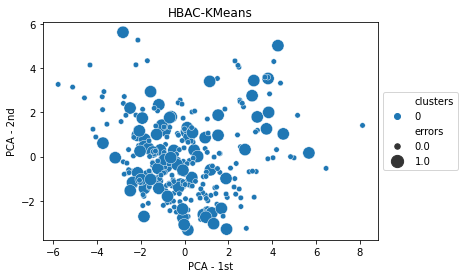

average_accuracy is:  0.75


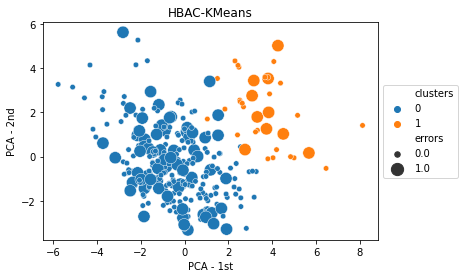

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1


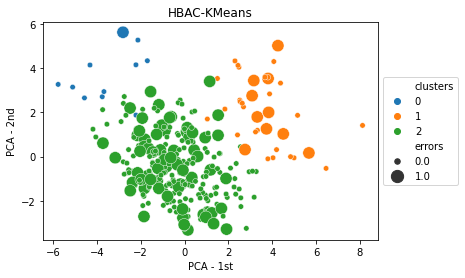

--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 1


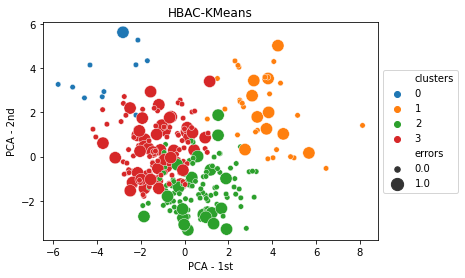

--> Cluster with the highest variance: 3


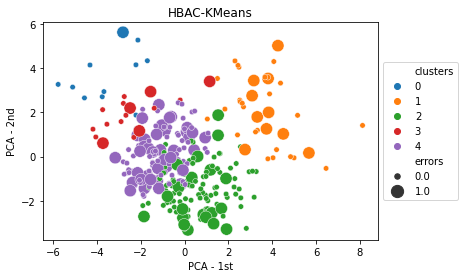

--> Cluster with the highest variance: 4


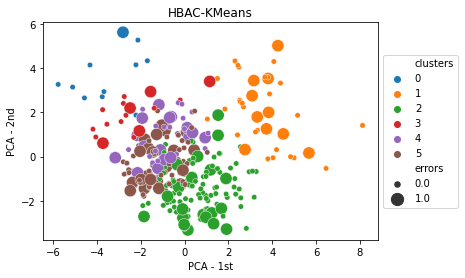

--> Cluster with the highest variance: 4
MAX_ITER
[0.0005346260190935576, 0.0005346260190935576, 0.007947549537914789, 0.007947549537914789, 0.007947549537914789, 0.007947549537914789, 0.007947549537914789, 0.007947549537914789, 0.011530122439607228, 0.009907154233710483, 0.01039140197551249, 0.01039140197551249, 0.01039140197551249, 0.01039140197551249, 0.01039140197551249, 0.01039140197551249, 0.01039140197551249, 0.01039140197551249]


In [7]:
MAX_ITER = 20
x = 0 # initial cluster number
initial_bias = 0
pca_plot(full_data)
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = split_cluster_size
minimal_acceptable_cluster_size = acc_cluster_size
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(variance_list)

### Analysing the clustering results

In [8]:
# Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

4 has bias -0.14252103882001632
0 has bias 0.1651462724127084
5 has bias -0.038662008133340975
2 has bias 0.10292934551133415
1 has bias -0.02312198129688625
3 has bias -0.04676782373726873
General accuracy of classifier on this dataset: 0.75
Number of clusters:  [4 0 5 2 1 3]
cluster 4 has the highest discrimination bias
-0.14252103882001632


In [11]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster.head()

Number of instances in discriminated cluster: 43
Number of errors in discriminated clusters:  16


,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
0,0.060492,0.002162,-0.049437,-0.764268,-0.665129,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0.0,0.0,0.0,4,-1.0
1,0.823703,0.254090,0.877513,1.084768,1.180823,0.943341,-0.447214,-0.623610,-0.592749,3.554766,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0.0,0.0,0.0,4,-1.0
2,-0.702720,-0.658246,0.877513,1.084768,2.235653,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0.0,0.0,0.0,4,-1.0
22,-0.702720,-0.420378,-0.976388,-0.764268,0.741311,-0.711644,-0.447214,-0.623610,-0.592749,3.554766,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0.0,0.0,0.0,4,-1.0
23,0.314895,0.012802,-0.976388,-0.764268,-1.016739,-0.711644,-0.447214,1.603567,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.8,1.0,0.0,1.0,4,-1.0


In [12]:
not_discriminated = full_data[full_data['clusters']!=c]
difference = (discriminated_cluster.mean()) - (not_discriminated.mean()) 
difference

month                             -0.435847
credit_amount                     -0.487887
investment_as_income_percentage    0.168765
residence_since                    0.136866
age                                0.180482
                                     ...   
predicted_class                   -0.051036
true_class                        -0.024523
errors                             0.142521
clusters                           1.241245
new_clusters                      -0.089494
Length: 63, dtype: float64

In [15]:
# unscaling the discriminated cluster
unscaled_discriminated = entire_dataset.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = entire_dataset.drop(discriminated_cluster.index)

display(unscaled_remaining.describe())
display(unscaled_discriminated.describe())

print(discriminated_cluster.index)

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,...,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000
mean,21.023346,3171.346304,3.027237,2.805447,35.272374,1.428016,1.151751,0.287938,0.264591,0.070039,...,0.089494,0.684825,0.198444,0.529183,0.470817,0.957198,0.042802,0.167315,0.326848,0.229572
std,12.184432,2751.449672,1.073126,1.086624,11.394375,0.608913,0.359479,0.453685,0.441976,0.255711,...,0.286013,0.465492,0.399606,0.500122,0.500122,0.202804,0.202804,0.373985,0.469977,0.421378
min,6.000000,338.000000,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1364.000000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,18.000000,2249.000000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,24.000000,3913.000000,4.000000,4.000000,41.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,60.000000,14782.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,...,43.000000,43.000000,43.0,43.000000,43.000000,43.0,43.0,43.000000,43.000000,43.000000
mean,15.883721,1887.372093,3.209302,2.953488,37.325581,1.441860,1.255814,0.232558,0.232558,0.093023,...,0.906977,0.023256,0.0,0.930233,0.069767,1.0,0.0,0.116279,0.302326,0.372093
std,8.074679,1371.411664,1.124577,1.068009,11.373991,0.589686,0.441481,0.427463,0.427463,0.293903,...,0.293903,0.152499,0.0,0.257770,0.257770,0.0,0.0,0.324353,0.464701,0.489083
min,4.000000,339.000000,1.000000,1.000000,21.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000
25%,11.000000,871.500000,2.000000,2.000000,27.500000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.0,1.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000
50%,14.000000,1459.000000,4.000000,3.000000,37.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.0,1.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000
75%,21.000000,2417.500000,4.000000,4.000000,44.500000,2.000000,1.500000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.0,1.000000,0.000000,1.0,0.0,0.000000,1.000000,1.000000
max,45.000000,7393.000000,4.000000,4.000000,66.000000,3.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.0,0.0,1.000000,1.000000,1.000000


Int64Index([  0,   1,   2,  22,  23,  31,  37,  38,  41,  44,  47,  48,  60,
             65,  88, 102, 103, 104, 106, 124, 133, 139, 150, 158, 176, 187,
            191, 205, 206, 208, 216, 231, 240, 259, 271, 274, 279, 281, 285,
            286, 287, 290, 294],
           dtype='int64')


#### Statistical test to check 
Welch’s Two-Samples T-Test for Unequal Variances to examine whether the differences in means for each feature are statistically significant.

In [17]:
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the p-value:', welch_i.pvalue)

month
this is the p-value: 0.0006516987531584097
credit_amount
this is the p-value: 6.316395796303527e-06
investment_as_income_percentage
this is the p-value: 0.32697068899251036
residence_since
this is the p-value: 0.40484186749441353
age
this is the p-value: 0.2779727868069728
number_of_credits
this is the p-value: 0.8877087071021803
people_liable_for
this is the p-value: 0.14857234917342785
status=A11
this is the p-value: 0.43893283761837676
status=A12
this is the p-value: 0.6525305766539782
status=A13
this is the p-value: 0.6309842775660721
status=A14
this is the p-value: 0.43757149689893793
credit_history=A30
this is the p-value: 0.3480772025655562
credit_history=A31
this is the p-value: 0.5802435141505722
credit_history=A32
this is the p-value: 0.6247231982554116
credit_history=A33
this is the p-value: 0.5875283090445695
credit_history=A34
this is the p-value: 0.9701530382952113
purpose=A40
this is the p-value: 0.8785834574696246
purpose=A41
this is the p-value: 0.025993312416186